In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_05 import *
torch.set_num_threads(2)

## ConvNet

In [ ]:
x_train,y_train,x_valid,y_valid = get_data()

In [ ]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [ ]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [ ]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [ ]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [ ]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

In [ ]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [ ]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [ ]:
model = get_cnn_model(data)

In [ ]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [ ]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [ ]:
%time run.fit(1, learn)

train: [1.80052609375, tensor(0.3767)]
valid: [0.56441240234375, tensor(0.8122)]
CPU times: user 9.75 s, sys: 6.02 s, total: 15.8 s
Wall time: 5.29 s


## CUDA

In [ ]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [ ]:
cbfs.append(CudaCallback)

In [ ]:
model = get_cnn_model(data)

In [ ]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [1.70935421875, tensor(0.4247, device='cuda:0')]
valid: [0.545311962890625, tensor(0.8320, device='cuda:0')]
train: [0.33943984375, tensor(0.8975, device='cuda:0')]
valid: [0.2418747314453125, tensor(0.9261, device='cuda:0')]
train: [0.186439921875, tensor(0.9447, device='cuda:0')]
valid: [0.12864632568359374, tensor(0.9615, device='cuda:0')]
CPU times: user 4.32 s, sys: 1.25 s, total: 5.57 s
Wall time: 5.49 s


## Refactor model

In [ ]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [ ]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [ ]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

This model can now work on any size input:

In [ ]:
nfs = [8,16,32,32]

In [ ]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [ ]:
#export
def get_runner(model, data, lr=0.6, cbs=None, loss_func = F.cross_entropy):
    opt = optim.SGD(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=cbfs + listify(cbs))

In [ ]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.4)

In [ ]:
run.fit(3, learn)

train: [2.02259859375, tensor(0.3017, device='cuda:0')]
valid: [1.07844677734375, tensor(0.6620, device='cuda:0')]
train: [0.4846076171875, tensor(0.8499, device='cuda:0')]
valid: [0.2560584716796875, tensor(0.9213, device='cuda:0')]
train: [0.22737287109375, tensor(0.9305, device='cuda:0')]
valid: [0.14688985595703125, tensor(0.9572, device='cuda:0')]


## Hooks

### Manual insertion

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [ ]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, lr=0.9)

In [ ]:
run.fit(2, learn)

train: [1.592655, tensor(0.4436, device='cuda:0')]
valid: [0.521791845703125, tensor(0.8505, device='cuda:0')]
train: [0.23923505859375, tensor(0.9260, device='cuda:0')]
valid: [0.12647113037109375, tensor(0.9602, device='cuda:0')]


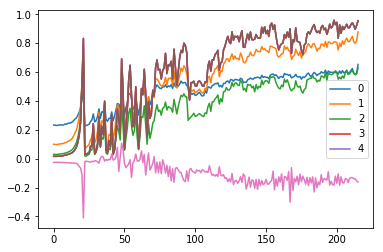

In [ ]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

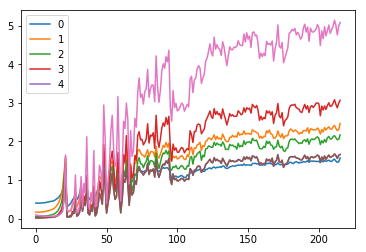

In [ ]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

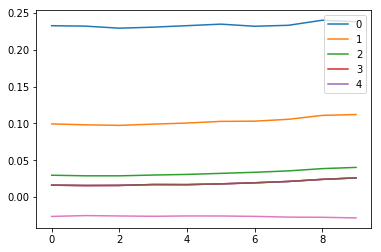

In [ ]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(5));

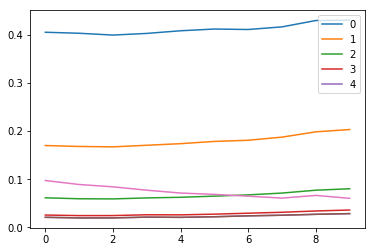

In [ ]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(5));

### Pytorch hooks

In [ ]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.5)

In [ ]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [ ]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [ ]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [ ]:
run.fit(1, learn)

train: [2.252628125, tensor(0.1782, device='cuda:0')]
valid: [2.871192578125, tensor(0.1554, device='cuda:0')]


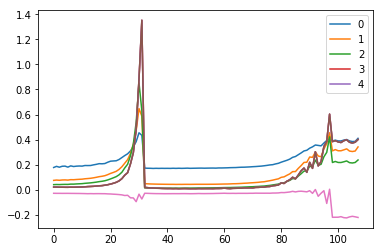

In [ ]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook class

In [ ]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [ ]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.5)

In [ ]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [ ]:
run.fit(1, learn)

train: [1.71869578125, tensor(0.4031, device='cuda:0')]
valid: [0.629295947265625, tensor(0.7878, device='cuda:0')]


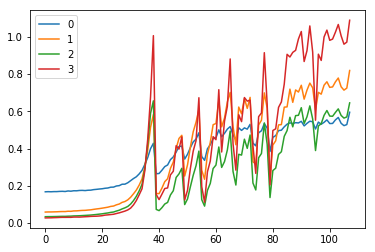

In [ ]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

### A Hooks class

In [ ]:
#export
class ListContainer():
    def __init__(self, items): self.items = items
    def __getitem__(self,i): return self.items[i]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self): return f"{self.__class__.__name__} ({len(self)} items)"

In [ ]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
        
    def remove(self):
        for h in self: h.remove()

In [ ]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, lr=0.9)

In [ ]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)

In [ ]:
hooks.remove()

In [ ]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [ ]:
x.mean(),x.std()

(tensor(0.0119, device='cuda:0'), tensor(1.0136, device='cuda:0'))

In [ ]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.2071, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3697, device='cuda:0', grad_fn=<StdBackward0>))

In [ ]:
for l in model:
    if isinstance(l, nn.Sequential): init.kaiming_normal_(l[0].weight)

In [ ]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.4888, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.9073, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.6772765625, tensor(0.4324, device='cuda:0')]
valid: [0.521271728515625, tensor(0.8343, device='cuda:0')]
train: [0.3992796875, tensor(0.8749, device='cuda:0')]
valid: [0.239741650390625, tensor(0.9252, device='cuda:0')]


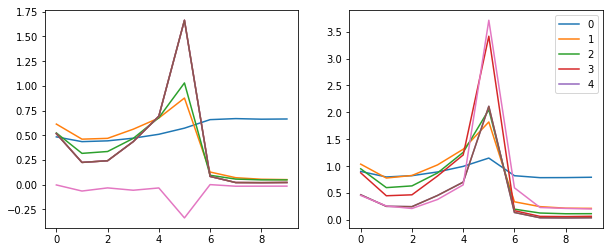

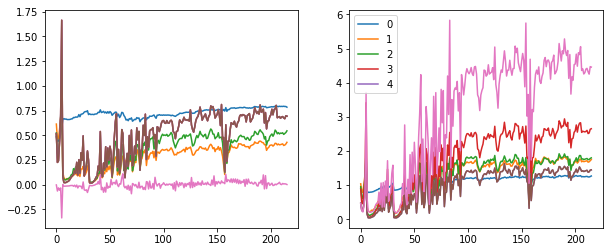

In [ ]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

### Other statistics

- pct < x
- percentiles

## Generalized ReLU

In [ ]:
#export
def get_cnn_layers(data, nfs, **kwargs):
    nfs = [1] + nfs
    return [conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs, **kwargs): return nn.Sequential(*get_cnn_layers(data, nfs, **kwargs))

def conv2d(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [ ]:
model =  SequentialModel(*get_cnn_layers(data, nfs, leak=0.1, sub=0.4, maxv=6.))

for l in model:
    if isinstance(l, nn.Sequential): init.kaiming_normal_(l[0].weight, a=0.1)

learn,run = get_runner(model, lr=0.9)

train: [0.490748515625, tensor(0.8494, device='cuda:0')]
valid: [0.14723616943359374, tensor(0.9559, device='cuda:0')]


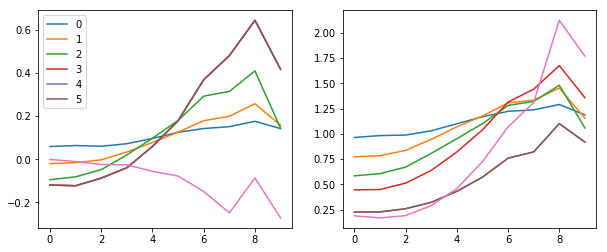

In [ ]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    h.remove()
    ax0.legend(range(6));

In [ ]:
#export
def init_cnn(m):
    for l in m:
        if isinstance(l, nn.Sequential):
            init.kaiming_normal_(l[0].weight, a=0.1)
            l[0].weight.data

In [ ]:
model =  nn.Sequential(*get_cnn_layers(data, nfs, leak=0.1, sub=0.4, maxv=6.))
init_cnn(model)
learn,run = get_runner(model, lr=0.9)

train: [0.496798203125, tensor(0.8479, device='cuda:0')]
valid: [0.15948818359375, tensor(0.9530, device='cuda:0')]
train: [0.129983642578125, tensor(0.9603, device='cuda:0')]
valid: [0.103526025390625, tensor(0.9686, device='cuda:0')]


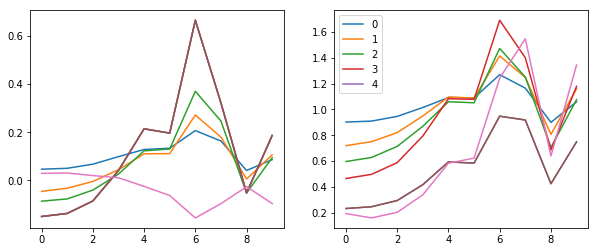

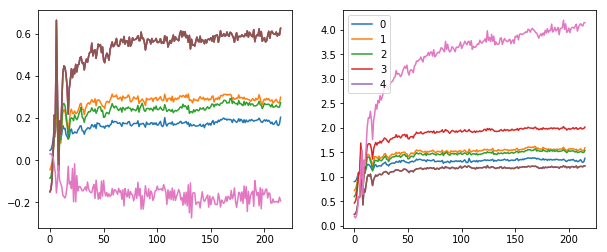

In [ ]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

In [ ]:
#export
def get_learn_run(nfs, data, lr, cbs=None):
    model = nn.Sequential(*get_cnn_layers(data, nfs, leak=0.1, sub=0.4, maxv=6.))
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs)

In [ ]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 

In [ ]:
learn,run = get_learn_run(nfs, 1., cbs=partial(ParamScheduler,'lr', sched))

In [ ]:
run.fit(8, learn)

train: [0.79113390625, tensor(0.7699, device='cuda:0')]
valid: [0.3256356201171875, tensor(0.8944, device='cuda:0')]
train: [0.26623271484375, tensor(0.9196, device='cuda:0')]
valid: [0.259093212890625, tensor(0.9182, device='cuda:0')]
train: [0.18276099609375, tensor(0.9434, device='cuda:0')]
valid: [0.12496890869140626, tensor(0.9649, device='cuda:0')]
train: [0.12673763671875, tensor(0.9612, device='cuda:0')]
valid: [0.1013431396484375, tensor(0.9686, device='cuda:0')]
train: [0.0822570703125, tensor(0.9746, device='cuda:0')]
valid: [0.077582763671875, tensor(0.9791, device='cuda:0')]
train: [0.0612361328125, tensor(0.9813, device='cuda:0')]
valid: [0.06586860961914062, tensor(0.9809, device='cuda:0')]
train: [0.048166259765625, tensor(0.9855, device='cuda:0')]
valid: [0.0648989990234375, tensor(0.9819, device='cuda:0')]
train: [0.041812529296875, tensor(0.9882, device='cuda:0')]
valid: [0.06230037841796875, tensor(0.9827, device='cuda:0')]


## Export

In [ ]:
!python notebook2script.py 06_cuda_cnn_hooks_init.ipynb

Converted 06_cuda_cnn_hooks_init.ipynb to nb_06.py
